# Предсказание оттока клиентов

# Первая часть. Исследование

Установим библиотеки для работы:

In [ ]:
!pip install catboost
!pip install scikit-plot
!pip install xgboost
!pip install seaborn

Проведем импорт библиотек:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import warnings

from catboost import Pool, CatBoostClassifier, cv

from pandas.core.common import random_state

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

from xgboost import XGBClassifier

In [ ]:
warnings.filterwarnings('ignore')

## Загрузка данных

Прочитаем файлы с данными для обучения:

In [ ]:
df_train = pd.read_csv(f"/content/train.csv")

In [ ]:
df_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
df_test = pd.read_csv(f"/content/test.csv)

In [ ]:
df_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

Разеделим колонки на числовые и категориальные:

In [ ]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## Подготовка данных


### Обработка пропущенный значений. Тип данных

Обработаем колонку `TotalSpent` - она должна быть числовой, и колонку `IsSeniorCitizen` - ее мы следаелм категориальной.

Поскольку сразу мы не может изменить тип, нужно найти в ней не числовые данные:

In [ ]:
df_train['TotalSpent'].value_counts().sort_values().tail()

19.65    6
20.05    6
19.75    8
20.2     9
         9
Name: TotalSpent, dtype: int64

Посмотрим сколько данных пропущено в колонке `TotalSpent`:

In [ ]:
df_train[df_train['TotalSpent'] == ' '].shape[0]

9

In [ ]:
df_test[df_test['TotalSpent'] == ' '].shape[0]

2

Перезапишем наши данные для обучения и тестрирования, а также приведем в нужный тип колонки `TotalSpent` и `IsSeniorCitizen`:

In [ ]:
median_total_spent_train = df_train['TotalSpent'][df_train['TotalSpent']!=' '].astype('float').median()
df_train['TotalSpent'] = df_train['TotalSpent'].replace(' ', median_total_spent_train)
df_train['TotalSpent'] = df_train['TotalSpent'].astype('float')

In [ ]:
median_total_spent_test = df_test['TotalSpent'][df_test['TotalSpent']!=' '].astype('float').median()
df_test['TotalSpent'] = df_test['TotalSpent'].replace(' ', median_total_spent_train)
df_test['TotalSpent'] = df_test['TotalSpent'].astype('float')

In [ ]:
df_train['IsSeniorCitizen'] = df_train['IsSeniorCitizen'].astype('object')

In [ ]:
df_test['IsSeniorCitizen'] = df_test['IsSeniorCitizen'].astype('object')

### Разделение выборки на обучающую и валидационную

Разделим выборки на обучающую и валидационную, а также определим признаки для обучения, и целевые признаки:

In [ ]:
features_train = df_train.drop('Churn', axis=1)
target_train = df_train['Churn']

In [ ]:
features_train, features_valid = train_test_split(features_train, test_size=0.25, random_state=123)
target_train, target_valid = train_test_split(target_train, test_size=0.25, random_state=123)

Посмотрим на баланс классов:

In [ ]:
target_train.value_counts()

0    2910
1    1051
Name: Churn, dtype: int64

Наблюдается дисбаланс, что требуется учитывать при дальнешей работе

### Масштабирование числовых признаков

In [ ]:
numeric = num_cols
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [ ]:
features_train[numeric].head()

,ClientPeriod,MonthlySpending,TotalSpent
2286,-0.213608,-1.468881,-0.769002
5142,0.883167,0.840399,1.172112
4014,0.720682,1.443396,1.392507
3478,0.314469,0.480920,0.423075
3989,1.614350,-0.123734,1.003265


In [ ]:
scaler.fit(df_test[numeric])
df_test[numeric] = scaler.transform(df_test[numeric])

In [ ]:
df_test[numeric].head()

,ClientPeriod,MonthlySpending,TotalSpent
0,0.394782,-0.274027,0.057007
1,-0.133958,1.147644,0.330299
2,-0.947404,0.401602,-0.696504
3,1.411590,0.326160,1.155641
4,1.574279,-1.481107,-0.384496


### Увеличение обучающей выборки

Поскольку данных немного, а также наблюдается дисбаланс классов целевых переменных, возможно при увеличении выборки, мы получим лучшие результаты.  
Определим функцию для увеличения обучающей выборки:

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=555)
    return features_upsampled, target_upsampled

Увеличем обучающею выборку:

In [ ]:
features_train_up, target_train_up = upsample(features_train, target_train, 4)
print(features_train_up.shape)
print(target_train_up.shape)

(7114, 19)
(7114,)


Посмотрим теперь на баланс:

In [ ]:
target_train_up.value_counts(normalize=True)

1    0.590947
0    0.409053
Name: Churn, dtype: float64

## Анализ данных

### Анализ числовых признаков

Посмотрим на распределение числовых признаков, для этого построим график распределения, а также диаграмму размаха:

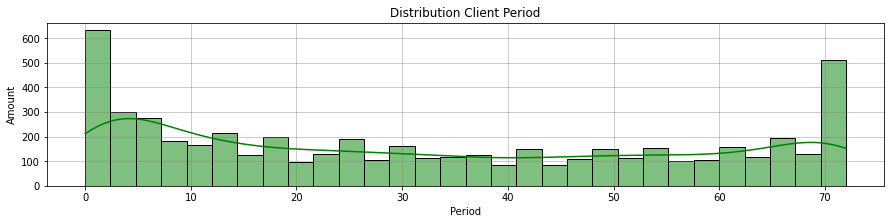

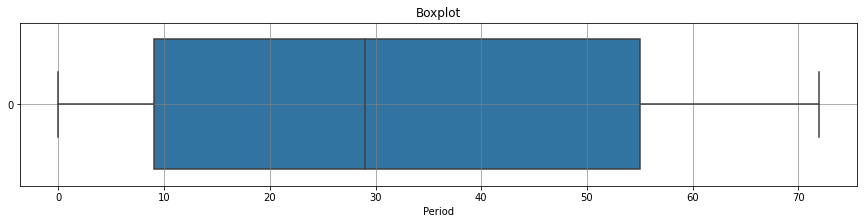

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df_train, x='ClientPeriod', kde=True, bins=30, color='green')

plt.title(f'Distribution Client Period')
plt.ylabel('Amount')
plt.xlabel('Period')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(0, 105, 10))
# plt.yticks(np.arange(0, 75000, 5000))
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df_train['ClientPeriod'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Period')
plt.grid(color='grey', axis='both', alpha=.8)
# plt.xticks(np.arange(0, 105, 10))
plt.show()

In [ ]:
df_train['ClientPeriod'].describe()

count    5282.000000
mean       32.397009
std        24.550326
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: ClientPeriod, dtype: float64

В целом данные достаточно распределены равномерно

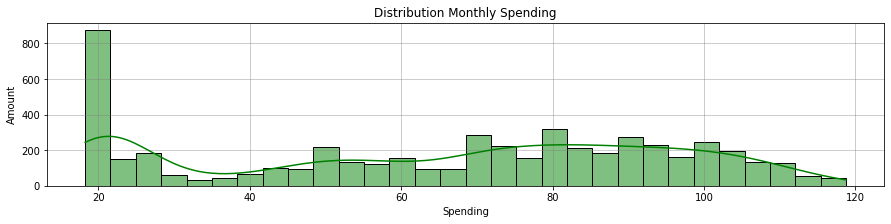

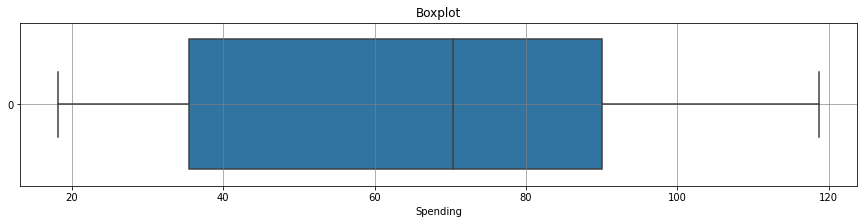

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df_train, x='MonthlySpending', kde=True, bins=30, color='green')

plt.title(f'Distribution Monthly Spending')
plt.ylabel('Amount')
plt.xlabel('Spending')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(0, 105, 10))
# plt.yticks(np.arange(0, 75000, 5000))
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df_train['MonthlySpending'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Spending')
plt.grid(color='grey', axis='both', alpha=.8)
# plt.xticks(np.arange(0, 105, 10))
plt.show()

In [ ]:
df_train['MonthlySpending'].describe()

count    5282.000000
mean       64.924754
std        30.176464
min        18.250000
25%        35.462500
50%        70.400000
75%        90.050000
max       118.750000
Name: MonthlySpending, dtype: float64

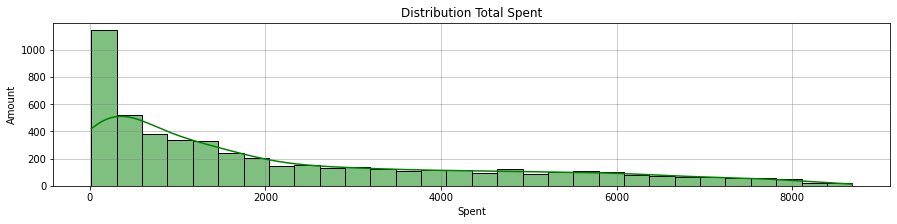

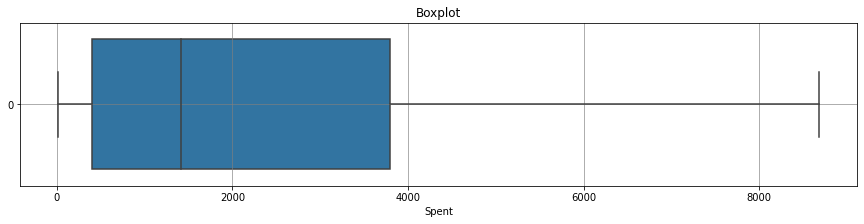

In [ ]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df_train, x='TotalSpent', kde=True, bins=30, color='green')

plt.title(f'Distribution Total Spent')
plt.ylabel('Amount')
plt.xlabel('Spent')
plt.grid(color='grey', axis='both', alpha=0.5)
# plt.xticks(np.arange(0, 105, 10))
# plt.yticks(np.arange(0, 75000, 5000))
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df_train['TotalSpent'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('Spent')
plt.grid(color='grey', axis='both', alpha=.8)
# plt.xticks(np.arange(0, 105, 10))
plt.show()

In [ ]:
df_train['TotalSpent'].describe()

count    5282.000000
mean     2289.889086
std      2267.371263
min        18.800000
25%       401.587500
50%      1410.250000
75%      3795.212500
max      8684.800000
Name: TotalSpent, dtype: float64

В числовых данных наблюдается скопления данных в начале графике, и постепенно снижается.  
При этом миданна для `ClientPeriod` и `TotalSpent` смешещена влево, а для `MonthlySpending` вправо.

Text(0.5, 1.0, 'Correlation Heatmap')

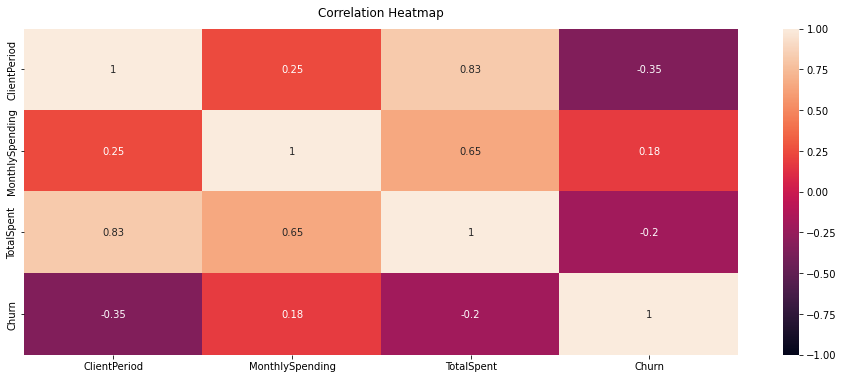

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Видим достаточно высокую корреляцию между TotalSpent и ClientPeriod.

### Анализ категориальных признаков

Посмотрим на количество данных категориальных, чтобы понять как строить график:

In [ ]:
len(cat_cols)

16

Посмотрим диграммы для категориальных данных:

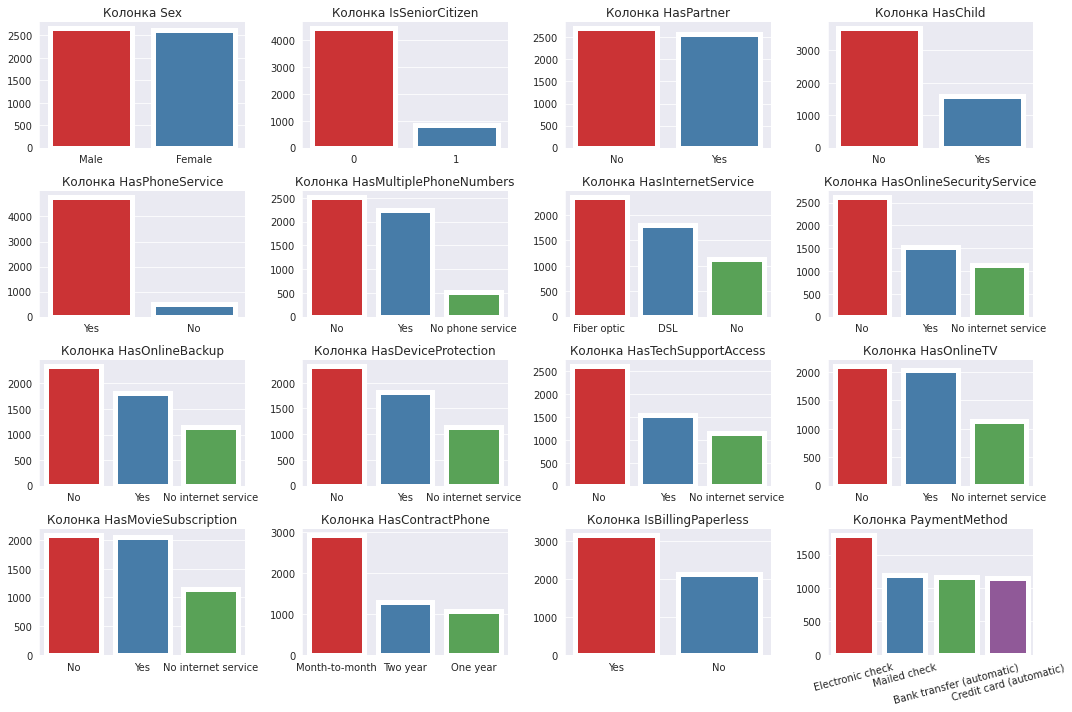

In [ ]:
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')
sns.set_palette('Set1')
plt.rcParams["figure.autolayout"] = True


for i in range(len(cat_cols)):
    plt.subplot(4, 4, i+1)
    data_barplot = df_train.groupby(cat_cols[i])['MonthlySpending'].agg(['count']).reset_index()
    data_barplot = data_barplot.sort_values(by=['count'], ascending=False)
    plt.title(f"Колонка {data_barplot.columns[0]}")
    sns.barplot(x=data_barplot.columns[0], y='count', data=data_barplot, linewidth=5).set(xlabel=None, ylabel=None)
    
locs, labels = plt.xticks()
plt.setp(labels, rotation=15)
sns.despine()

Наблюдаются не равнемерности в колонках `IsSeniorCitizen`, `HasChild`, `HasPhoneService`, возможно данные признаки целесообразно убрать из задачи обучения

Выведем количество значений в категориальных колонках:

## Применение линейных моделей

Создадим признаки с one-hot-encoding кодированием:

In [ ]:
features_train_lr = pd.get_dummies(features_train, drop_first=True)
features_valid_lr = pd.get_dummies(features_valid, drop_first=True)
target_train_lr = pd.get_dummies(target_train, drop_first=True)
target_valid_lr = pd.get_dummies(target_valid, drop_first=True)
df_train_lr = pd.get_dummies(df_train, drop_first=True)

### Logistic Regression

Обучим модель логической регрессии:

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(features_train_lr, target_train_lr)

LogisticRegression()

In [ ]:
predictions_valid = lr_model.predict_proba(features_valid_lr)[:, 1]

In [ ]:
probabilities_test = lr_model.predict_proba(features_valid_lr)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_score_tree = roc_auc_score(target_valid_lr, probabilities_one_test) 
"ROC-AUC score: %.4f" % roc_auc_score_tree

'ROC-AUC score: 0.8359'

Обучим логическую регрессию с кросс валдиацией и подбором гиперпараметров:

In [ ]:
lr_cv_model = LogisticRegressionCV(Cs=np.logspace(-3, 2, 30), random_state=777, scoring='roc_auc')

In [ ]:
lr_cv_model.fit(features_train_lr, target_train_lr)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.48735211e-03, 2.21221629e-03, 3.29034456e-03,
       4.89390092e-03, 7.27895384e-03, 1.08263673e-02, 1.61026203e-02,
       2.39502662e-02, 3.56224789e-02, 5.29831691e-02, 7.88046282e-02,
       1.17210230e-01, 1.74332882e-01, 2.59294380e-01, 3.85662042e-01,
       5.73615251e-01, 8.53167852e-01, 1.26896100e+00, 1.88739182e+00,
       2.80721620e+00, 4.17531894e+00, 6.21016942e+00, 9.23670857e+00,
       1.37382380e+01, 2.04335972e+01, 3.03919538e+01, 4.52035366e+01,
       6.72335754e+01, 1.00000000e+02]),
                     random_state=777, scoring='roc_auc')

In [ ]:
probabilities_test = lr_cv_model.predict_proba(features_valid_lr)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_score_tree = roc_auc_score(target_valid_lr, probabilities_one_test) 
"ROC-AUC: %.4f" % roc_auc_score_tree

'ROC-AUC: 0.8361'

### Вывод

Лучший ROC-AUC логичтиеской регрессии = 0.8361.

## Применение градиентного бустинга

### eXtreme Gradient Boosting Сlassifier

XGBoost расшифровывается как eXtreme Gradient Boosting, алгоритм повышения, основанный на алгоритме деревьев решений с градиентным усилением. XGBoost применяет лучший метод регуляризации для уменьшения переобучения, и это одно из отличий от повышения градиента.  
- «xgboost» — это открытый исходная библиотека, которая предоставляет алгоритмы машинного обучения для методов повышения градиента.   
- xgboost.XGBClassifier — это класс, совместимый с scikit-learn API для классификации.

In [ ]:
%%time

xgbc = XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 

xgbc.fit(features_train_lr, target_train_lr)

CPU times: user 576 ms, sys: 89.8 ms, total: 666 ms
Wall time: 849 ms


Выведем ROC-AUC score:

In [ ]:
scores = cross_val_score(xgbc, features_valid_lr, target_valid_lr, cv=5, scoring='roc_auc')

In [ ]:
print("ROC-AUC score: %.4f" % scores.mean())

ROC-AUC score: 0.8198


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, features_valid_lr, target_valid_lr, cv=kfold, scoring='roc_auc' )

In [ ]:
print("ROC-AUC score: %.4f" % kf_cv_scores.mean())

ROC-AUC score: 0.8142


Применем подбор параметров по сетке:

Для экономии времени, закоментим поиск гиперпараметров

In [ ]:
# %%time

# xgbc_cv = XGBClassifier()

# parameters = {'nthread':[4],
#               'objective':['binary:logistic'],
#               'learning_rate': np.linspace(0.01, 0.7, 10),
#               'max_depth': [6, 7, 8],
#               'min_child_weight': [11],
#               'silent': [1],
#               'subsample': [0.8],
#               'colsample_bytree': [0.7],
#               'n_estimators': [100, 200, 500],
#               'missing':[-999],
#               'seed': [123]}

# xgbc_cv_model = GridSearchCV(xgbc_cv, parameters, n_jobs=5, 
#                    scoring='roc_auc', verbose=2, refit=True)

# xgbc_cv_model.fit(features_train_lr, target_train_lr)

Лучшие параметры:

In [ ]:
# xgbc_cv_model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 11,
 'missing': -999,
 'n_estimators': 200,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 123,
 'silent': 1,
 'subsample': 0.8}

In [ ]:
%%time

xgbc_best = XGBClassifier()

XGBClassifier(colsample_bytree=0.7,
              learning_rate=0.01,
              max_depth=6,
              min_child_weight=11,
              missing=-999,
              n_estimators=200,
              nthread=4,
              objective='binary:logistic',
              seed=123,
              silent=1,
              subsample=0.8
              ) 

xgbc_best.fit(features_train_lr, target_train_lr)

CPU times: user 574 ms, sys: 4.12 ms, total: 579 ms
Wall time: 731 ms


In [ ]:
probabilities_test = xgbc_best.predict_proba(features_valid_lr)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_score_tree = roc_auc_score(target_valid_lr, probabilities_one_test) 
"ROC-AUC: %.4f" % roc_auc_score_tree

'ROC-AUC: 0.8391'

Построим ROC кривую:

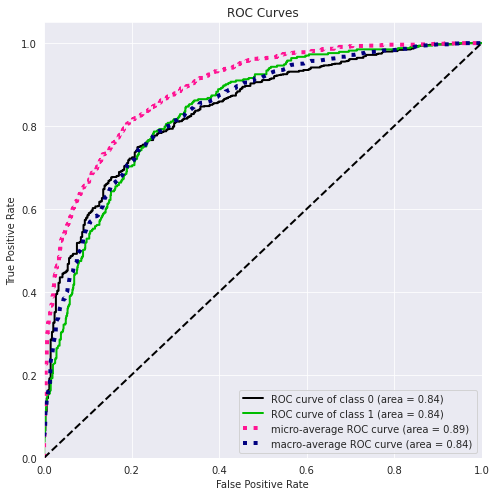

In [ ]:
plt.rcParams["figure.figsize"] = (7, 7)
y_true = target_valid_lr
y_probas = xgbc_best.predict_proba(features_valid_lr)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

### Cat Boost Classifier

Обучим cat boost clasifier, без подбора гиперпараметров:

In [ ]:
cbc_model = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', use_best_model=True, random_seed=123)

In [ ]:
cbc_model.fit(features_train, target_train, cat_features=cat_cols, eval_set=(features_valid, target_valid))

Learning rate set to 0.044521
0:	learn: 0.8029550	test: 0.7896864	best: 0.7896864 (0)	total: 104ms	remaining: 1m 44s
1:	learn: 0.8217726	test: 0.7992167	best: 0.7992167 (1)	total: 134ms	remaining: 1m 6s
2:	learn: 0.8231454	test: 0.8027744	best: 0.8027744 (2)	total: 167ms	remaining: 55.4s
3:	learn: 0.8212094	test: 0.8009827	best: 0.8027744 (2)	total: 216ms	remaining: 53.7s
4:	learn: 0.8234834	test: 0.8065555	best: 0.8065555 (4)	total: 230ms	remaining: 45.8s
5:	learn: 0.8241577	test: 0.8069841	best: 0.8069841 (5)	total: 250ms	remaining: 41.5s
6:	learn: 0.8326666	test: 0.8155190	best: 0.8155190 (6)	total: 329ms	remaining: 46.7s
7:	learn: 0.8389784	test: 0.8212286	best: 0.8212286 (7)	total: 371ms	remaining: 46s
8:	learn: 0.8438806	test: 0.8244383	best: 0.8244383 (8)	total: 415ms	remaining: 45.7s
9:	learn: 0.8452817	test: 0.8254231	best: 0.8254231 (9)	total: 435ms	remaining: 43s
10:	learn: 0.8464040	test: 0.8258669	best: 0.8258669 (10)	total: 468ms	remaining: 42.1s
11:	learn: 0.8460336	test

Выведем AUC:

In [ ]:
roc_auc_score(target_valid, cbc_model.predict_proba(features_valid)[:, 1]) 

0.8409776172934067

Обучим модель с подбором гиперпараметров:


In [ ]:
# %%time

# CBC = CatBoostClassifier()
# parameters = {
#               'depth': [2, 3], 
#               'loss_function': ['Logloss'],
#               #"task_type" : "GPU",
#               'grow_policy': ['Lossguide'],
#               'auto_class_weights': ['Balanced'],
#               'learning_rate': np.linspace(0.03, 0.1, 10), 
#               'iterations': [250, 300], 
#               'subsample': np.linspace(0.55, 0.6, 5), 
#               'l2_leaf_reg': np.linspace(3, 3.5, 5), 
#               'random_strength': np.linspace(1.1, 1.2, 5), 
#               'min_data_in_leaf': [5],               
#               'eval_metric' : ['AUC:hints=skip_train~false'], 
#               'use_best_model' : [True],
#               'random_seed' : [123]}
# Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5, n_jobs=-1)
# Grid_CBC.fit(features_train, target_train, cat_features=cat_cols, eval_set=(features_valid, target_valid))

Поиск лучших гиперпараметров занял: Wall time: 2h 22min 25s

In [ ]:
# Grid_CBC.best_params_

{'auto_class_weights': 'Balanced',
 'depth': 3,
 'eval_metric': 'AUC:hints=skip_train~false',
 'grow_policy': 'Lossguide',
 'iterations': 250,
 'l2_leaf_reg': 3.25,
 'learning_rate': 0.06888888888888889,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 5,
 'random_seed': 123,
 'random_strength': 1.2,
 'subsample': 0.5875,
 'use_best_model': True}

### Лучшая модель

Обучим модель с лучшими гиперпараметрами, и сохраним ее:

In [ ]:
cbc_best_model = CatBoostClassifier(
    auto_class_weights = 'Balanced', depth = 3, 
    grow_policy = 'Lossguide', iterations = 250, l2_leaf_reg = 3.25,
    learning_rate =  0.06888888888888889, loss_function = 'Logloss', min_data_in_leaf = 5,
    random_seed = 123, random_strength = 1.2, subsample = 0.5875, use_best_model = True,
    eval_metric ='AUC:hints=skip_train~false')

cbc_best_model.fit(features_train, target_train, cat_features=cat_cols, eval_set=(features_valid, target_valid))

0:	learn: 0.7983091	test: 0.7689815	best: 0.7689815 (0)	total: 7.51ms	remaining: 1.87s
1:	learn: 0.8158623	test: 0.7908566	best: 0.7908566 (1)	total: 15.7ms	remaining: 1.95s
2:	learn: 0.8307966	test: 0.8042516	best: 0.8042516 (2)	total: 24.4ms	remaining: 2s
3:	learn: 0.8368638	test: 0.8110297	best: 0.8110297 (3)	total: 30.9ms	remaining: 1.9s
4:	learn: 0.8373590	test: 0.8147667	best: 0.8147667 (4)	total: 37ms	remaining: 1.81s
5:	learn: 0.8373169	test: 0.8152105	best: 0.8152105 (5)	total: 44.9ms	remaining: 1.82s
6:	learn: 0.8397627	test: 0.8160281	best: 0.8160281 (6)	total: 53.4ms	remaining: 1.85s
7:	learn: 0.8404282	test: 0.8172651	best: 0.8172651 (7)	total: 59.6ms	remaining: 1.8s
8:	learn: 0.8418083	test: 0.8178609	best: 0.8178609 (8)	total: 66.5ms	remaining: 1.78s
9:	learn: 0.8427945	test: 0.8203381	best: 0.8203381 (9)	total: 72.9ms	remaining: 1.75s
10:	learn: 0.8441978	test: 0.8232438	best: 0.8232438 (10)	total: 79.2ms	remaining: 1.72s
11:	learn: 0.8463255	test: 0.8271039	best: 0.827

Сохраним лучшую модель:

In [ ]:
# cbc_best_model.save_model('/content/CBC_model')

Вызов сохранненой модели:

In [ ]:
# cbc_best_model = CatBoostClassifier()
# cbc_best_model.load_model('/content/CBC_model')

Проверим ROC-AUС:

In [ ]:
roc_auc_score(target_valid, cbc_best_model.predict_proba(features_valid)[:, 1])

0.8416326245273613

Запишем score с kaggle:

Score: 0.85124

### ROC-кривые

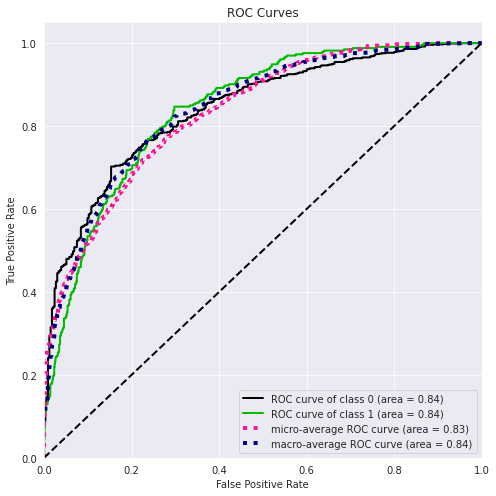

In [ ]:
y_true = target_valid
y_probas = cbc_best_model.predict_proba(features_valid)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

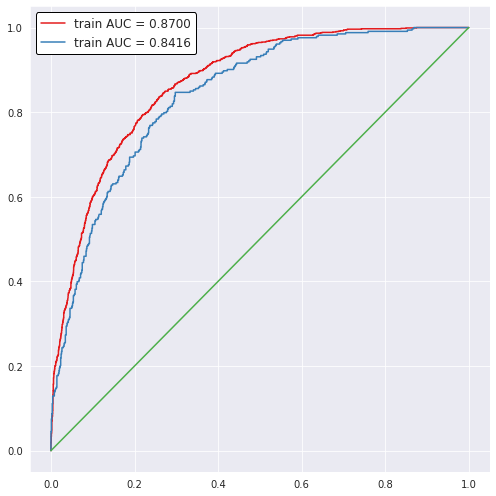

In [ ]:
train_pred = cbc_best_model.predict_proba(features_train)[:, 1]
train_auc = roc_auc_score(target_train, train_pred)
valid_pred = cbc_best_model.predict_proba(features_valid)[:, 1]
valid_auc = roc_auc_score(target_valid, valid_pred)

plt.plot(*roc_curve(target_train, train_pred)[:2], label='train AUC = {:.4f}'.format(train_auc))
plt.plot(*roc_curve(target_valid, valid_pred)[:2], label='train AUC = {:.4f}'.format(valid_auc))

legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

plt.show()

### Вывод

Лучшее качество Cat Boost Classifier удалось достить с параметрами:  
- 'auto_class_weights': 'Balanced',   
- 'depth': 3,   
- 'eval_metric': 'AUC:hints=skip_train~false',   
- 'grow_policy': 'Lossguide',   
- 'iterations': 250,   
- 'l2_leaf_reg': 3.25,  
- 'learning_rate': 0.06888888888888889, 
- 'loss_function': 'Logloss',
- 'min_data_in_leaf': 5, 
- 'random_seed': 123, 
- 'random_strength': 1.2,
- 'subsample': 0.5875, 
- 'use_best_model': True.  

При этом `ROC-AUC` = 0.84163

# Предсказания

In [ ]:
pred = cbc_best_model.predict_proba(df_test)[:, 1]

submission = pd.DataFrame({'Id':df_test.index,'Churn':pred})

In [ ]:
submission.head()

,Id,Churn
0,0,0.111615
1,1,0.870067
2,2,0.896343
3,3,0.032472
4,4,0.018982


In [ ]:
# submission.to_csv('/content/submission.csv', index=False)

Score kaggle = 0.85124